# Human In Loop Paper summarizer

## Overview
Create a human in loop where there is a RAG agent that is integrated with a PDF paper data.
When the user requests for a summary, it gives a summary of the paper.
After reviewing the summary, the human can intervene and further ask for top 5 web search results.

## Motivation

When the paper summary is created for the user by the LLM using the vector store, a manual evaluation step is required to understand if there is a need for further continuation, re- summarize, re write the query and many more.
This tutorial will be a good start to explore further possibilities.



## Flow Diagram

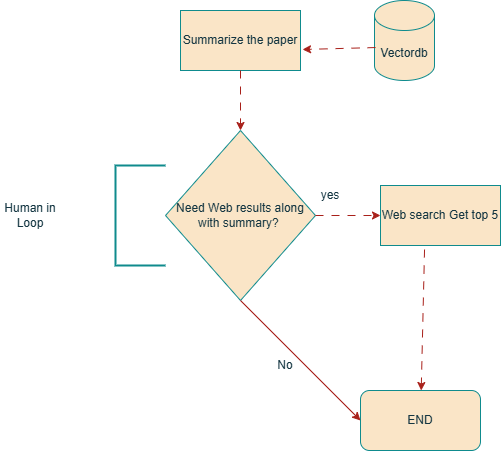

## Use cases

1.   Evaluate the results
2.   Provide a manual override
3.   Breakpoint in the LangGraph code before continuation
4.   Choose different workflows based on user options which can trigger different pathways




In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core  faiss-cpu  pypdf langchain_community mdutils datasets langchain_huggingface xmltodict sentence-transformers langchain_groq langchain_ollama langchain_mistralai fitz jq langchain_cohere frontend
%pip install -U PyMuPDF openai rapidocr-onnxruntime

## Common Imports

In [ ]:
from PIL import Image
import io
import os
from dotenv import load_dotenv

import google.generativeai as genai
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
#from langchain_cohere import ChatCohere, CohereEmbeddings
# Load environment variables from a .env file
from google.colab import userdata
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')

## Langsmith tracking
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get('TAVILY_API_KEY')
os.environ["COHERE_API_KEY"]=userdata.get('COHERE_API_KEY')
import nest_asyncio
from typing import List, TypedDict, Any, Tuple
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from datetime import date, datetime
from langgraph.checkpoint.memory import MemorySaver
import getpass
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import create_react_agent
from langchain.prompts import PromptTemplate
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_cohere import ChatCohere, CohereEmbeddings
import fitz  # PyMuPDF
from PIL import Image
import io
import os
import base64
import httpx
from langchain_core.messages import HumanMessage
import google.generativeai as genai
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_cohere import ChatCohere, CohereEmbeddings
nest_asyncio.apply()
from google.colab import drive
from langchain_core.pydantic_v1 import BaseModel, Field
from pprint import pprint
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import PromptTemplate
from typing import List
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


In [7]:
#Constants
foldersjson={
    "tutorialDataset":"/content/drive/MyDrive/Colab Notebooks/colab_data/tutorialData",
}
MODEL_NAME="gpt-3.5-turbo-0125"
DATABASE_PATH="/content/drive/MyDrive/Database"
# LLM with function call, can use ChatGRroq with llama3 or ChatOllama as well for open-source options
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llmImage=ChatOpenAI(model="gpt-4o",temperature=0, max_tokens=2000)
INDEX_NAME="s41467Paper"

## ETL (Extract, Transform, Load)

## Input Data
The paper from this link https://www.nature.com/articles/s41467-024-53645-z



In [8]:
def load_files(file_paths):
    documents = []
    for file in file_paths:
        extension = get_file_type(file)
        print("Extension", extension)
        if extension == '.txt':
            loader = TextLoader(file)
            l=loader.load()
        elif extension == '.csv':
            loader = CSVLoader(file)
            l=loader.load()
        elif extension == '.json':
            loader = JSONLoader(file, jq_schema=".",json_lines=True,text_content=False)
            l=loader.load()
        elif extension == '.pdf':
            loader = PyPDFLoader(file, extract_images=True)
            l=loader.load()
        else:
            continue
        documents.extend(l)
    return documents

def get_file_type(file_path):
    _, extension = os.path.splitext(file_path)
    return extension.lower()

def getFilePathList(folderPath):
  allFileswithPath=[]
  folders=folderPath
  for item in os.listdir(folders):
    filewithPath=folders+"/"+item
    print(filewithPath)
    allFileswithPath.append(filewithPath)
    return allFileswithPath

def saveTextDB(indexName,allFileswithPath):
  #NO NEED TO RUN THIS CODE WHEN THE DATABASE IS ALREADY CREATED
  documents=load_files(allFileswithPath)
  text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
  final_documents=text_splitter.split_documents(documents)
  embeddings=OpenAIEmbeddings()
  vecStore=FAISS.from_documents(final_documents,embeddings)
  # Save the vector DB to your local
  dbPapaers =vecStore.save_local(folder_path=DATABASE_PATH, index_name=indexName)

def loadDBRetreiever(indexName):
  #allFileswithPath =getFilePathList(foldersjson["tutorialDataset"])
  #saveTextDB(indexName,allFileswithPath)
  db=FAISS.load_local(folder_path=DATABASE_PATH, index_name=indexName, embeddings=OpenAIEmbeddings(),allow_dangerous_deserialization=True)
  paperRetreiever=db.as_retriever()
  return paperRetreiever

def createRetTool(retreiever, toolname, tooldesc):
    retrieverList=[]
    retriever_tool=create_retriever_tool(retreiever,toolname, tooldesc)
    retrieverList.append(retriever_tool)
    return retrieverList

## LANG GRAPH Implementation

RAGAgent: The agent is connected to the Tool Node which retreives the nature paper

WebAgent: This agent connects to web search results.

The Human in loop interruption happens before the flow reaches WebAgent. After confirming that the user wants to access web results it invokes the web agent. If not it exits.
I am attaching the web results to the human message.

In [41]:
# Set up the tool
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import MessagesState

retriever=loadDBRetreiever(INDEX_NAME)
tools1 = createRetTool(retriever, "PaperRAG", "All the details about the paper Systematic assessment of the achieved emission reductions of carbon crediting projects ")
tavily_tool = TavilySearchResults(max_results=5)

tool_node1 = ToolNode(tools1)
tools2 = [tavily_tool]

web_agent = create_react_agent(
    llm,
    tools=tools2,
    state_modifier="Based on the user query, get me the top 5 results related to the paper",
)


def web_node(state: MessagesState) -> MessagesState:
    result = web_agent.invoke(state)
    print("Web Agent Result")
    print(result)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="WebAgent"
    )
    return {
        # share internal message history of research agent with other agents
        "messages": result["messages"],
    }

# Define the function that determines whether to continue or not
def should_continue(state):
    print("should continue?")
    messages = state["messages"]
    last_message = messages[-1]
    print("Last message")
    print(last_message)
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        print("Transition to Websearch")
        return "next"
    else:
        print("Go to tool action node")
        return "continue"

# Define the function that calls the model
def call_agent(state):
    print("*****************************IN RAG Agent*****************************")
    model = ChatOpenAI(model=MODEL_NAME)
    model = model.bind_tools(tools1)
    messages = state["messages"]
    print(messages)
    try:
      response = model.invoke(messages)
    except:
      print("Something wrong!")
    print(response)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

def call_web_agent(state):
  print("*****************************In Web agent*****************")
  model = ChatOpenAI(model=MODEL_NAME)
  model = model.bind_tools(tools2)
  messages = state["messages"]
  print(messages)
  response = model.invoke(messages)
  return {"messages": [response]}

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("RAGagent", call_agent)
workflow.add_node("RAGaction", tool_node1)
workflow.add_node("WEBAgent",web_node)

workflow.add_edge(START, "RAGagent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "RAGagent",
    should_continue,
    {
        "continue": "RAGaction",
        "next": "WEBAgent",
    },
)

workflow.add_edge("RAGaction", "RAGagent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["WEBAgent"])


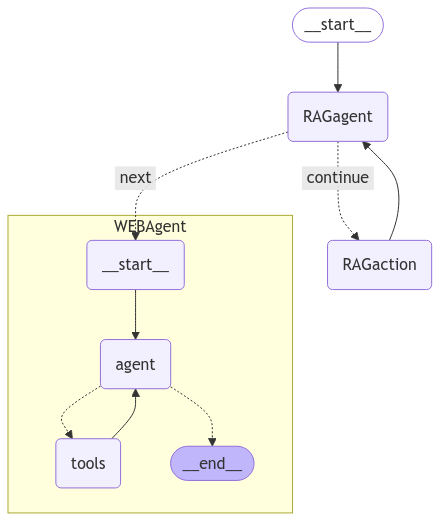

In [42]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Something happened")
    pass

In [43]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="Give me a summary of the paper 'Systematic assessment of the achieved emission reductions of carbon crediting projects'")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

try:
    user_approval = input("Do you want a web search for this paper? (yes/no): ")
except:
    user_approval = "yes"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for event in app.stream(None, thread, stream_mode="values"):
      event["messages"][-1].pretty_print()
else:
      print("User did not need webresults!Completed Successfully")

================================ Human Message =================================

Give me a summary of the paper 'Systematic assessment of the achieved emission reductions of carbon crediting projects'
*****************************IN RAG Agent*****************************
[HumanMessage(content="Give me a summary of the paper 'Systematic assessment of the achieved emission reductions of carbon crediting projects'", additional_kwargs={}, response_metadata={}, id='b1367a76-f36c-4cd9-9a45-86c91e181a5c')]
content='' additional_kwargs={'tool_calls': [{'id': 'call_BLO4lKVrWwStccQ3Ivw1QdEu', 'function': {'arguments': '{"query":"Systematic assessment of the achieved emission reductions of carbon crediting projects"}', 'name': 'PaperRAG'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 91, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_pred